# Autoencoder

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sys
print (sys.version)

3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 14:01:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import importlib
import pandas as pd
from scipy.stats import bernoulli
from matplotlib import cm
from numpy import linalg as LA
from mpl_toolkits.mplot3d import Axes3D # This import has side effects required for the kwarg projection='3d' in the call to fig.add_subplot
import random

import generative_lib

In [4]:
importlib.reload(generative_lib)

<module 'generative_lib' from '/Users/joriococola/Desktop/CS 6140/project 6140/GitHub/CS6140_LatentClassify/ipython notebooks/generative_lib.py'>

In [5]:
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

## Setting

In [7]:
# Hyperparameters
random_seed = 123
learning_rate = 0.005
num_epochs = 5
DOWNLOAD = True

# Architecture
num_features = 784
num_hidden_1 = 32

## Fashion-MNIST DATASET

In [8]:
# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.FashionMNIST(root='data_2', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=DOWNLOAD)

test_dataset = datasets.FashionMNIST(root='data_2', 
                              train=False, 
                              transform=transforms.ToTensor(),
                                    download=DOWNLOAD)

Processing...
Done!


In [9]:
batch_size = 38
batch_size_test = len(test_dataset)
SHUFFLE_TR = True
SHUFFLE_TS = False

In [10]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=SHUFFLE_TR)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=SHUFFLE_TS)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([38, 1, 28, 28])
Image label dimensions: torch.Size([38])


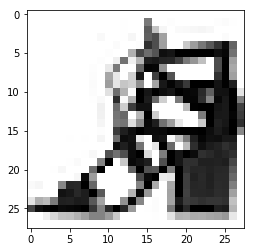

In [11]:
tmp = images[10].reshape([28,28])
plt.imshow(tmp, cmap = 'binary')

## Model

In [12]:
torch.manual_seed(random_seed)
model = generative_lib.AE_1L(num_features,num_hidden_1)

## COST AND OPTIMIZER

In [13]:
cost_fn = torch.nn.BCELoss() #torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) 

## Training

In [14]:
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.view(-1, 28*28)
        
        ### FORWARD AND BACK PROP
        decoded = model(features)
        cost = cost_fn(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost))

Epoch: 001/005 | Batch 000/1578 | Cost: 0.6983
Epoch: 001/005 | Batch 500/1578 | Cost: 0.4063
Epoch: 001/005 | Batch 1000/1578 | Cost: 0.3719
Epoch: 001/005 | Batch 1500/1578 | Cost: 0.3156
Epoch: 002/005 | Batch 000/1578 | Cost: 0.3213
Epoch: 002/005 | Batch 500/1578 | Cost: 0.3076
Epoch: 002/005 | Batch 1000/1578 | Cost: 0.3062
Epoch: 002/005 | Batch 1500/1578 | Cost: 0.3127
Epoch: 003/005 | Batch 000/1578 | Cost: 0.2948
Epoch: 003/005 | Batch 500/1578 | Cost: 0.2804
Epoch: 003/005 | Batch 1000/1578 | Cost: 0.3197
Epoch: 003/005 | Batch 1500/1578 | Cost: 0.2935
Epoch: 004/005 | Batch 000/1578 | Cost: 0.2804
Epoch: 004/005 | Batch 500/1578 | Cost: 0.3003
Epoch: 004/005 | Batch 1000/1578 | Cost: 0.2985
Epoch: 004/005 | Batch 1500/1578 | Cost: 0.3283
Epoch: 005/005 | Batch 000/1578 | Cost: 0.2792
Epoch: 005/005 | Batch 500/1578 | Cost: 0.3136
Epoch: 005/005 | Batch 1000/1578 | Cost: 0.2967
Epoch: 005/005 | Batch 1500/1578 | Cost: 0.2873


## Evaluation

In [15]:
n_images = 9
image_width = 28

orig_images = features[:n_images]

# test of encoder/decoder 
enc = model.encoder(orig_images)
dec = model.decoder(enc)

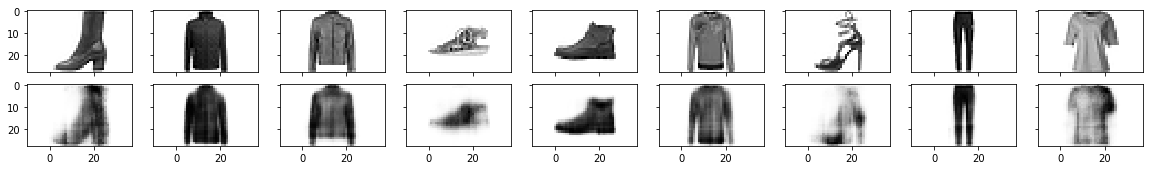

In [16]:
# reconstruction of train set
fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, dec]):
        ax[i].imshow(img[i].detach().reshape((image_width, image_width)), cmap='binary')

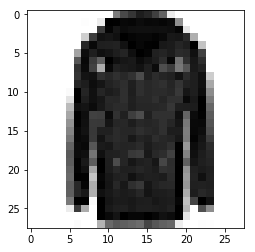

In [17]:
# Random img in the test set
test_img = test_dataset[random.randint(0, len(test_dataset))][0]
plt.imshow(test_img.reshape([image_width,image_width]),cmap='binary')

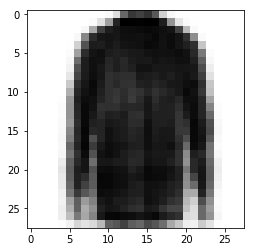

In [18]:
# Reconstruction using autoencoder

test_enc = model.encoder(test_img.reshape(image_width*image_width))
test_dec = model.decoder(test_enc).detach().numpy()

plt.imshow(test_dec.reshape([image_width,image_width]),cmap='binary')

## Latent Codes

In [19]:
batch_size = len(train_dataset)
batch_size_test = len(test_dataset)
SHUFFLE_TR = False
SHUFFLE_TS = False

In [21]:
Xtrain = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=SHUFFLE_TR)

Xtest = DataLoader(dataset=test_dataset, batch_size=batch_size_test, shuffle=SHUFFLE_TS)

In [22]:
for batch_idx, (features, targets_Train) in enumerate(Xtrain):
    features = features.view(-1, 28*28)
print(batch_idx)

0


In [23]:
latent_Train = model.encoder(features)
print(latent_Train.shape)
print(targets_Train.shape)

torch.Size([60000, 32])
torch.Size([60000])


In [24]:
for batch_idx, (features, targets_Test) in enumerate(Xtest):
    features = features.view(-1, 28*28)
print(batch_idx)

0


In [25]:
latent_Test = model.encoder(features)
print(latent_Test.shape)
print(targets_Test.shape)

torch.Size([10000, 32])
torch.Size([10000])


In [26]:
torch.save(latent_Train, 'FMNIST_latent_tr.pth')
torch.save(latent_Test, 'FMNIST_latent_ts.pth')

torch.save(targets_Train, 'FMNIST_targets_tr.pth')
torch.save(targets_Test, 'FMNIST_targets_ts.pth')